<h1>C4 Solution</h1>

<h3>Install and import</h3>

In [2]:
%%capture
import sys
!{sys.executable} -m pip install smdebug torch torchvision tqdm

In [3]:
import os
import boto3
import sagemaker
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs, ProfilerConfig, FrameworkProfile
from sagemaker.analytics import HyperparameterTuningJobAnalytics

<h3>Get the data and copy it to S3</h3>

In [10]:
%%capture
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip
!aws s3 cp dogImages s3://udacitysolution-2023-ricard/ --recursive

<h3>Set up parameters, estimator, and tuner</h3>

In [4]:
hyperparameter_ranges = {
    "learning_rate": ContinuousParameter(0.001, 0.1),
    "batch_size": CategoricalParameter([32, 64, 128, 256, 512]),
}

role = sagemaker.get_execution_role()

objective_metric_name = "Test Loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "Test Loss", "Regex": "Testing Loss: ([0-9\\.]+)"}]

In [13]:
estimator = PyTorch(
    entry_point="hpo.py",
    base_job_name='pytorch_dog_hpo',
    role=role,
    framework_version="1.4.0",
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    py_version='py3'
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=2,
    max_parallel_jobs=1,  # you once have one ml.g4dn.xlarge instance available
    objective_type=objective_type
)

<h3>Fit the tuner</h3>

In [14]:
os.environ['SM_CHANNEL_TRAINING']='s3://udacitysolution-2023-ricard/'
os.environ['SM_MODEL_DIR']='s3://udacitysolution-2023-ricard/model/'
os.environ['SM_OUTPUT_DATA_DIR']='s3://udacitysolution-2023-ricard/output/'
tuner.fit({"training": "s3://udacitysolution-2023-ricard/"})

Using provided s3_resource


No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


.................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................!


<h3>Describe the tuning results</h3>


In [17]:
exp = HyperparameterTuningJobAnalytics(
  hyperparameter_tuning_job_name='pytorch-training-230730-1635')#pytorch-training-230730-1635-003-e68b1468

jobs = exp.dataframe()

jobs.sort_values('FinalObjectiveValue', ascending=0)

batch_size  learning_rate                            TrainingJobName  \
0      "128"       0.055628  pytorch-training-230730-1635-003-e68b1468   
1       "64"       0.006845  pytorch-training-230730-1635-002-56d362bd   
2      "512"       0.011041  pytorch-training-230730-1635-001-213777d4   

  TrainingJobStatus  FinalObjectiveValue         TrainingStartTime  \
0         Completed                580.0 2023-07-30 17:02:02+00:00   
1         Completed                261.0 2023-07-30 16:40:25+00:00   
2            Failed                  NaN 2023-07-30 16:36:24+00:00   

            TrainingEndTime  TrainingElapsedTimeSeconds  
0 2023-07-30 17:22:32+00:00                      1230.0  
1 2023-07-30 17:00:25+00:00                      1200.0  
2 2023-07-30 16:40:07+00:00                       223.0

## Imp: If kernel dies, how to continue from a completed training job

In [8]:
BetterTrainingJobName='pytorch-training-230730-1635-003-e68b1468'
my_estimator = sagemaker.estimator.Estimator.attach(BetterTrainingJobName)
my_estimator.hyperparameters()
best_estimator=my_estimator


2023-07-30 17:22:34 Starting - Found matching resource for reuse
2023-07-30 17:22:34 Downloading - Downloading input data
2023-07-30 17:22:34 Training - Training image download completed. Training in progress.
2023-07-30 17:22:34 Uploading - Uploading generated training model
2023-07-30 17:22:34 Completed - Resource released due to keep alive period expiry


<h3>Prepare to perform Training on Best Estimator</h3>

In [15]:
best_estimator=tuner.best_estimator()

NameError: name 'tuner' is not defined

In [19]:
best_estimator.hyperparameters()

{'_tuning_objective_metric': 'Test Loss',
 'batch_size': '"128"',
 'learning_rate': '0.05562791524984103',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch_dog_hpo-2023-07-30-16-35-03-778"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-900395491479/pytorch_dog_hpo-2023-07-30-16-35-03-778/source/sourcedir.tar.gz"'}

In [20]:
hyperparameters = {"batch_size": int(best_estimator.hyperparameters()['batch_size'].replace('"', '')), \
                   "learning_rate": best_estimator.hyperparameters()['learning_rate']}
hyperparameters

{'batch_size': 128, 'learning_rate': '0.05562791524984103'}

In [21]:
rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

In [22]:
hook_config = DebuggerHookConfig(
    hook_parameters={
        "train.save_interval": "1",
        "eval.save_interval": "1"
    }
)

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=1)
)

Framework profiling will be deprecated from tensorflow 2.12 and pytorch 2.0 in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


<h2>Creating an Estimator</h2>

In [23]:
#adjust this cell to accomplish multi-instance training
estimator = PyTorch(
    entry_point='hpo.py',
    base_job_name='dog-pytorch',
    role=role,
    instance_count=1,
    instance_type='ml.m5.2xlarge',
    framework_version='1.4.0',
    py_version='py3',
    hyperparameters=hyperparameters,
    ## Debugger and Profiler parameters
    rules = rules,
    debugger_hook_config=hook_config,
    profiler_config=profiler_config,
)

In [24]:
estimator.fit({"training": "s3://udacitysolution-2023-ricard/"}, wait=False)

Using provided s3_resource


INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: dog-pytorch-2023-07-31-15-48-25-364


<h2>Creating an Estimator - Multi-Instance Training,</h2>

In [45]:
###in this cell, create and fit an estimator using multi-instance training
estimator = PyTorch(
    entry_point='hpo.py',
    base_job_name='dog-pytorch',
    role=role,
    instance_count=5,
    instance_type='ml.m5.2xlarge',
    framework_version='1.4.0',
    py_version='py3',
    hyperparameters=hyperparameters,
    ## Debugger and Profiler parameters
    rules = rules,
    debugger_hook_config=hook_config,
    profiler_config=profiler_config,
)

In [46]:
estimator.fit({"training": "s3://udacitysolution-2023-ricard/"}, wait=False)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: dog-pytorch-2023-07-31-16-28-58-266


Using provided s3_resource


<h2>Deployment</h2>

In [49]:
model_location=estimator.model_data

In [50]:
import sagemaker
import boto3
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs
from sagemaker.debugger import ProfilerConfig, FrameworkProfile

from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor


In [51]:
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()


class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )

In [52]:
pytorch_model = PyTorchModel(model_data=model_location, role=role, entry_point='infernce2.py',py_version='py3',
                             framework_version='1.4',
                             predictor_cls=ImagePredictor)

In [54]:
predictor = pytorch_model.deploy(initial_instance_count=1, instance_type='ml.m5.large')


INFO:sagemaker:Repacking model artifact (s3://sagemaker-us-east-1-900395491479/dog-pytorch-2023-07-31-16-28-58-266/output/model.tar.gz), script artifact (None), and dependencies ([]) into single tar.gz file located at s3://sagemaker-us-east-1-900395491479/pytorch-inference-2023-07-31-16-45-37-761/model.tar.gz. This may take some time depending on model size...
INFO:sagemaker:Creating model with name: pytorch-inference-2023-07-31-16-45-53-244
INFO:sagemaker:Creating endpoint-config with name pytorch-inference-2023-07-31-16-45-54-046
INFO:sagemaker:Creating endpoint with name pytorch-inference-2023-07-31-16-45-54-046


-----!

In [55]:
import requests
#request_dict={ "url": "https://cdn1-www.cattime.com/assets/uploads/2011/12/file_2744_british-shorthair-460x290-460x290.jpg" }
request_dict={ "url": "https://s3.amazonaws.com/cdn-origin-etr.akc.org/wp-content/uploads/2017/11/20113314/Carolina-Dog-standing-outdoors.jpg" }

img_bytes = requests.get(request_dict['url']).content
type(img_bytes)

bytes

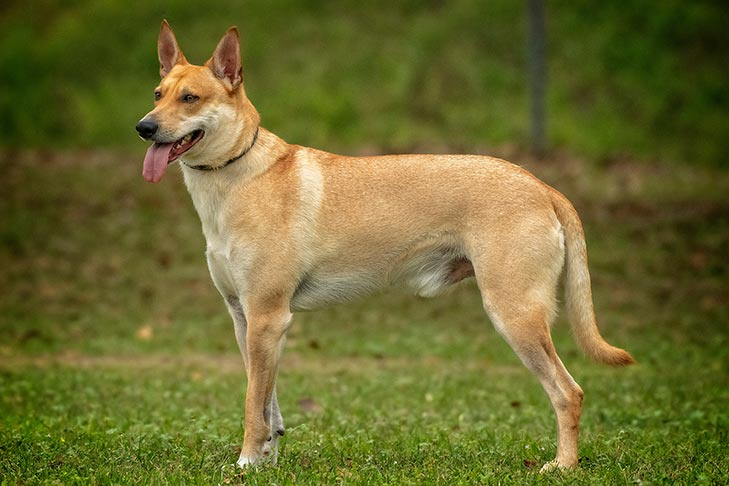

In [56]:
from PIL import Image
import io
Image.open(io.BytesIO(img_bytes))

In [57]:
response=predictor.predict(img_bytes, initial_args={"ContentType": "image/jpeg"})

In [58]:
import json
response2=predictor.predict(json.dumps(request_dict), initial_args={"ContentType": "application/json"})

In [59]:
type(response2[0][0])

float

In [60]:
response2[0]

[0.6086635589599609,
 0.4133589267730713,
 0.3317559063434601,
 0.6570028066635132,
 0.22621525824069977,
 0.6265989542007446,
 0.22158317267894745,
 0.5427917242050171,
 -0.059289637953042984,
 0.32368573546409607,
 0.4969884157180786,
 -0.10988837480545044,
 0.18170835077762604,
 0.5911688804626465,
 0.6723883152008057,
 0.46126508712768555,
 0.13258586823940277,
 0.24059993028640747,
 0.23702523112297058,
 0.4059014618396759,
 0.4800487756729126,
 0.289962500333786,
 0.4262635409832001,
 0.5226911306381226,
 -0.07214174419641495,
 0.18727271258831024,
 0.5375852584838867,
 -0.26341068744659424,
 0.8098011016845703,
 0.34801310300827026,
 0.39774537086486816,
 0.6618579030036926,
 -0.05422191694378853,
 0.5233261585235596,
 0.3541719615459442,
 0.5643346309661865,
 0.33058419823646545,
 0.43479347229003906,
 0.6175631880760193,
 0.4311128258705139,
 0.4865529537200928,
 -0.17072322964668274,
 0.24232998490333557,
 0.49404260516166687,
 0.4122694134712219,
 0.609549880027771,
 0.47209

In [62]:
import torch
import numpy as np
np.argmax(response, 1)

array([28])